# Рекурентные сети для обработки последовательностей

**Задача**
Выяснить какая архитектура больше подходит для задачи сантимент анализа
1. построить свёрточные архитектуры 
2. построить различные архитектуры с RNN
3. построить совместные архитектуры CNN -> RNN  и (RNN -> CNN)
4. сдлать выводы что получилось лучше


In [1]:
# попробуем запрограммировать простую рекурентную сеть. Возьмем датасет с прошлого занятия

import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_val = pd.read_csv("data/val.csv")



In [2]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [3]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [113]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, SimpleRNN, LSTM, GRU, Masking, Reshape
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.callbacks import EarlyStopping  

In [5]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [6]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)



In [7]:
y_train = df_train['class'].values
y_val = df_val['class'].values

In [219]:
num_epoch = 3
f1_metrics_models ={}

# Сверточные архитектуры

In [220]:
model = Sequential([
    Embedding(input_dim=word_count, output_dim=64, input_shape=(X_train.shape[1],)),
    Conv1D(128, 3),
    Activation("relu"),
    Conv1D(64, 3),
    Activation("relu"),
    GlobalMaxPool1D(),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 27, 64)            16518912  
                                                                 
 conv1d_48 (Conv1D)          (None, 25, 128)           24704     
                                                                 
 activation_48 (Activation)  (None, 25, 128)           0         
                                                                 
 conv1d_49 (Conv1D)          (None, 23, 64)            24640     
                                                                 
 activation_49 (Activation)  (None, 23, 64)            0         
                                                                 
 global_max_pooling1d_18 (G  (None, 64)                0         
 lobalMaxPooling1D)                                              
                                                     

In [221]:
model.fit(X_train, y_train, batch_size=128, epochs=num_epoch, 
          validation_data=(X_valid, y_val))

Epoch 1/3
1418/1418 [==============================] - 165s 116ms/step - loss: 0.5200 - accuracy: 0.7312 - val_loss: 0.5031 - val_accuracy: 0.7443
Epoch 2/3
1418/1418 [==============================] - 164s 116ms/step - loss: 0.2216 - accuracy: 0.9102 - val_loss: 0.6003 - val_accuracy: 0.7323
Epoch 3/3
1418/1418 [==============================] - 165s 116ms/step - loss: 0.0611 - accuracy: 0.9781 - val_loss: 0.8900 - val_accuracy: 0.7283


In [222]:
test_pred_proba = model.predict(X_valid)

709/709 [==============================] - 1s 905us/step


In [223]:
test_pred = test_pred_proba.round()

In [224]:
from sklearn.metrics import classification_report, f1_score

In [225]:
# отчет по метрикам
def get_classification_report(y_test_true, y_test_pred):
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))

In [226]:
get_classification_report(y_val, test_pred)

TEST

              precision    recall  f1-score   support

           0       0.68      0.84      0.75     11234
           1       0.79      0.62      0.70     11449

    accuracy                           0.73     22683
   macro avg       0.74      0.73      0.73     22683
weighted avg       0.74      0.73      0.73     22683



In [227]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, plot_confusion_matrix, plot_precision_recall_curve, precision_recall_curve, recall_score, plot_roc_curve

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])


    plt.show()

In [228]:
%matplotlib inline
import matplotlib.pyplot as plt

/tmp/ipykernel_4163/1996997817.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))


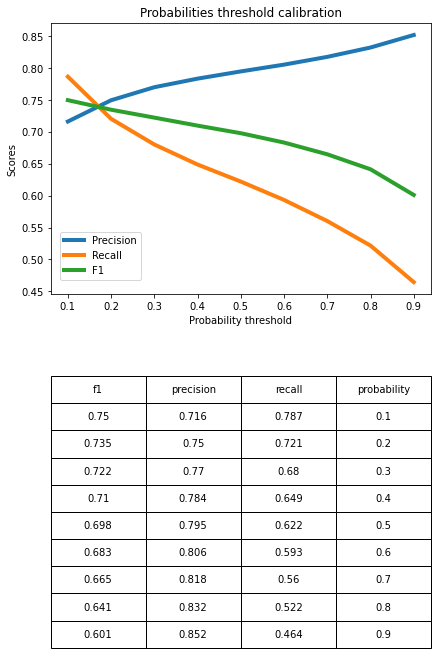

In [229]:
show_proba_calibration_plots(test_pred_proba, y_val)

In [230]:
test_pred= np.where(test_pred_proba.round(2)>0.2, 1, 0)
test_pred

array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [231]:
get_classification_report(y_val, test_pred)

TEST

              precision    recall  f1-score   support

           0       0.72      0.76      0.74     11234
           1       0.75      0.72      0.73     11449

    accuracy                           0.74     22683
   macro avg       0.74      0.74      0.74     22683
weighted avg       0.74      0.74      0.74     22683



In [232]:
f1_metrics_models['cnn'] = round(f1_score(y_val, test_pred),4)

In [233]:
f1_metrics_models

{'cnn': 0.7339}

# RNN архитектуры

# SimpleRNN

In [234]:
model = Sequential([
    Embedding(input_dim=word_count, output_dim=64, input_shape=(X_train.shape[1],)),
    Masking(mask_value=0.0),
    SimpleRNN(64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 27, 64)            16518912  
                                                                 
 masking_30 (Masking)        (None, 27, 64)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_96 (Dense)            (None, 32)                2080      
                                                                 
 dense_97 (Dense)            (None, 16)                528       
                                                                 
 dense_98 (Dense)            (None, 1)                 17        
                                                                 
Total params: 16529793 (63.06 MB)
Trainable params: 1

In [235]:
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=num_epoch,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/3
1276/1276 [==============================] - 144s 112ms/step - loss: 0.5245 - accuracy: 0.7267 - val_loss: 0.4761 - val_accuracy: 0.7644
Epoch 2/3
1276/1276 [==============================] - 143s 112ms/step - loss: 0.2283 - accuracy: 0.9068 - val_loss: 0.5489 - val_accuracy: 0.7440


In [236]:
score = model.evaluate(X_valid, y_val, batch_size=128, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

178/178 [==============================] - 0s 2ms/step - loss: 0.6058 - accuracy: 0.7274


Test score: 0.6057695746421814
Test accuracy: 0.7274169921875


709/709 [==============================] - 1s 1ms/step


/tmp/ipykernel_4163/1996997817.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))


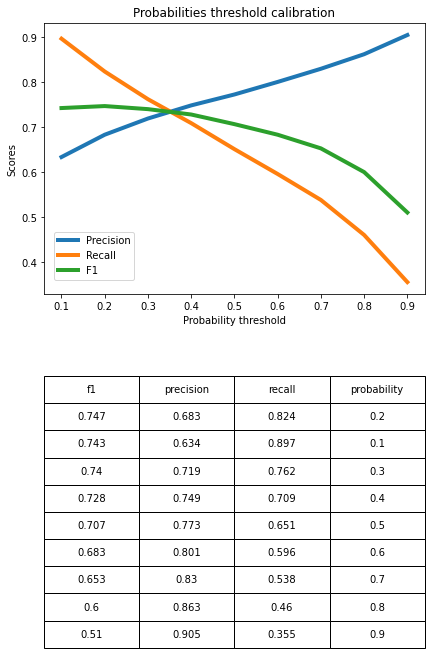

In [237]:
test_pred_proba = model.predict(X_valid)
test_pred = test_pred_proba.round()
show_proba_calibration_plots(test_pred_proba, y_val)

In [238]:
test_pred= np.where(test_pred_proba.round(2)>0.2, 1, 0)
get_classification_report(y_val, test_pred)

TEST

              precision    recall  f1-score   support

           0       0.77      0.61      0.68     11234
           1       0.68      0.82      0.75     11449

    accuracy                           0.72     22683
   macro avg       0.73      0.72      0.72     22683
weighted avg       0.73      0.72      0.72     22683



In [239]:
f1_metrics_models['simple_rnn'] = round(f1_score(y_val, test_pred),4)

# LSTM

In [240]:
model = Sequential([
    Embedding(input_dim=word_count, output_dim=64, input_shape=(X_train.shape[1],)),
    Masking(mask_value=0.0),
    LSTM(64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 27, 64)            16518912  
                                                                 
 masking_31 (Masking)        (None, 27, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_99 (Dense)            (None, 32)                2080      
                                                                 
 dense_100 (Dense)           (None, 16)                528       
                                                                 
 dense_101 (Dense)           (None, 1)                 17        
                                                                 
Total params: 16554561 (63.15 MB)
Trainable params: 1

In [241]:
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=num_epoch,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/3
1276/1276 [==============================] - 149s 116ms/step - loss: 0.5253 - accuracy: 0.7282 - val_loss: 0.4769 - val_accuracy: 0.7645
Epoch 2/3
1276/1276 [==============================] - 148s 116ms/step - loss: 0.2560 - accuracy: 0.8949 - val_loss: 0.5658 - val_accuracy: 0.7411


In [242]:
score = model.evaluate(X_valid, y_val, batch_size=128, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

178/178 [==============================] - 1s 6ms/step - loss: 0.6069 - accuracy: 0.7355


Test score: 0.6069344282150269
Test accuracy: 0.735528826713562


709/709 [==============================] - 2s 3ms/step


/tmp/ipykernel_4163/1996997817.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))


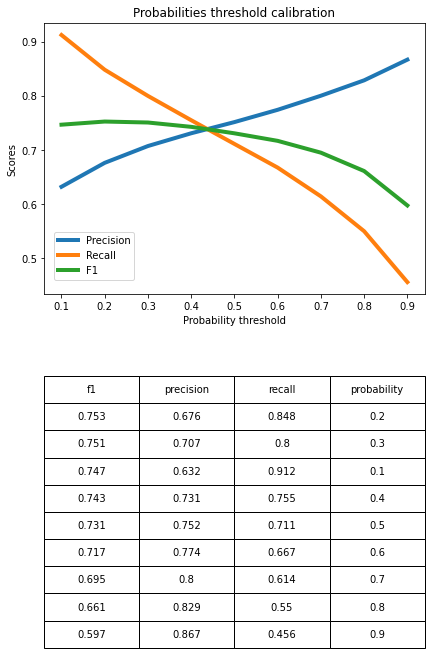

In [243]:
test_pred_proba = model.predict(X_valid)
test_pred = test_pred_proba.round()
show_proba_calibration_plots(test_pred_proba, y_val)

In [244]:
test_pred= np.where(test_pred_proba.round(2)>0.3, 1, 0)
get_classification_report(y_val, test_pred)

TEST

              precision    recall  f1-score   support

           0       0.76      0.67      0.71     11234
           1       0.71      0.80      0.75     11449

    accuracy                           0.73     22683
   macro avg       0.74      0.73      0.73     22683
weighted avg       0.74      0.73      0.73     22683



In [245]:
f1_metrics_models['lstm'] = round(f1_score(y_val, test_pred),4)

# GRU

In [246]:
model = Sequential([
    Embedding(input_dim=word_count, output_dim=64, input_shape=(X_train.shape[1],)),
    Masking(mask_value=0.0),
    GRU(64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 27, 64)            16518912  
                                                                 
 masking_32 (Masking)        (None, 27, 64)            0         
                                                                 
 gru_25 (GRU)                (None, 64)                24960     
                                                                 
 dense_102 (Dense)           (None, 32)                2080      
                                                                 
 dense_103 (Dense)           (None, 16)                528       
                                                                 
 dense_104 (Dense)           (None, 1)                 17        
                                                                 
Total params: 16546497 (63.12 MB)
Trainable params: 1

In [247]:
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=num_epoch,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/3
1276/1276 [==============================] - 150s 116ms/step - loss: 0.5194 - accuracy: 0.7316 - val_loss: 0.4769 - val_accuracy: 0.7634
Epoch 2/3
1276/1276 [==============================] - 148s 116ms/step - loss: 0.2444 - accuracy: 0.8996 - val_loss: 0.5746 - val_accuracy: 0.7402


In [248]:
score = model.evaluate(X_valid, y_val, batch_size=128, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

178/178 [==============================] - 1s 4ms/step - loss: 0.6398 - accuracy: 0.7313


Test score: 0.6397775411605835
Test accuracy: 0.7312965393066406


709/709 [==============================] - 2s 3ms/step


/tmp/ipykernel_4163/1996997817.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))


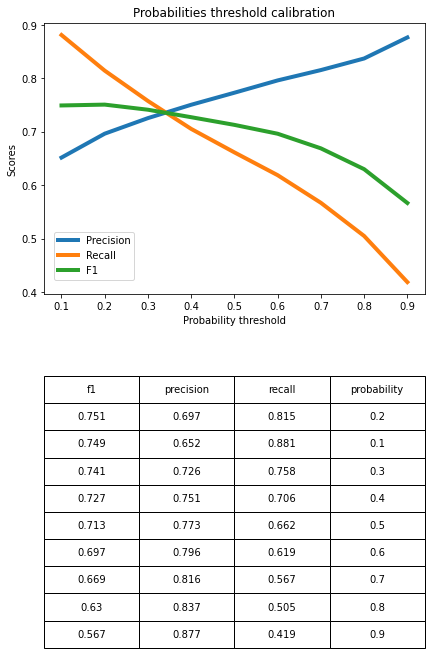

In [249]:
test_pred_proba = model.predict(X_valid)
test_pred = test_pred_proba.round()
show_proba_calibration_plots(test_pred_proba, y_val)

In [250]:
test_pred= np.where(test_pred_proba.round(2)>0.4, 1, 0)
get_classification_report(y_val, test_pred)

TEST

              precision    recall  f1-score   support

           0       0.72      0.76      0.74     11234
           1       0.75      0.70      0.73     11449

    accuracy                           0.73     22683
   macro avg       0.73      0.73      0.73     22683
weighted avg       0.73      0.73      0.73     22683



In [251]:
f1_metrics_models['gru'] = round(f1_score(y_val, test_pred),4)

# CNN->RNN

In [252]:
model = Sequential([
    Embedding(input_dim=word_count, output_dim=64, input_shape=(X_train.shape[1],)),
    Conv1D(128, 3),
    Activation("relu"),
    Conv1D(64, 3),
    Activation("relu"),
    Masking(mask_value=0.0),
    GRU(64),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 27, 64)            16518912  
                                                                 
 conv1d_50 (Conv1D)          (None, 25, 128)           24704     
                                                                 
 activation_50 (Activation)  (None, 25, 128)           0         
                                                                 
 conv1d_51 (Conv1D)          (None, 23, 64)            24640     
                                                                 
 activation_51 (Activation)  (None, 23, 64)            0         
                                                                 
 masking_33 (Masking)        (None, 23, 64)            0         
                                                                 
 gru_26 (GRU)                (None, 64)              

In [253]:
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=num_epoch,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/3
1276/1276 [==============================] - 152s 118ms/step - loss: 0.5210 - accuracy: 0.7302 - val_loss: 0.4784 - val_accuracy: 0.7644
Epoch 2/3
1276/1276 [==============================] - 149s 117ms/step - loss: 0.2103 - accuracy: 0.9149 - val_loss: 0.6545 - val_accuracy: 0.7362


In [254]:
score = model.evaluate(X_valid, y_val, batch_size=128, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

178/178 [==============================] - 1s 6ms/step - loss: 0.7595 - accuracy: 0.7216


Test score: 0.7595468163490295
Test accuracy: 0.7215976715087891


709/709 [==============================] - 3s 3ms/step


/tmp/ipykernel_4163/1996997817.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))


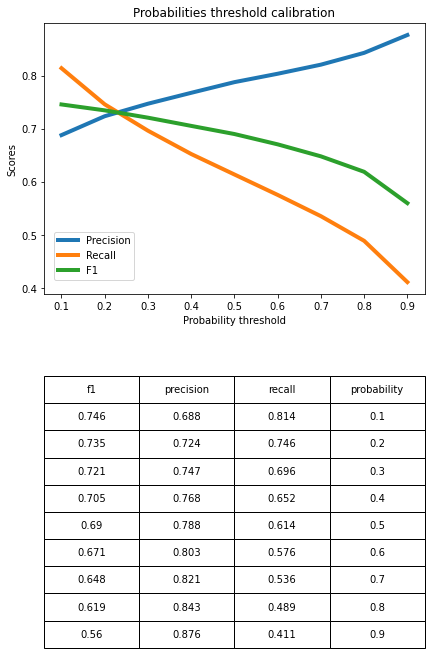

In [255]:
test_pred_proba = model.predict(X_valid)
test_pred = test_pred_proba.round()
show_proba_calibration_plots(test_pred_proba, y_val)

In [256]:
test_pred= np.where(test_pred_proba.round(2)>0.3, 1, 0)
get_classification_report(y_val, test_pred)

TEST

              precision    recall  f1-score   support

           0       0.71      0.76      0.73     11234
           1       0.75      0.69      0.72     11449

    accuracy                           0.73     22683
   macro avg       0.73      0.73      0.73     22683
weighted avg       0.73      0.73      0.73     22683



In [257]:
f1_metrics_models['cnn_gru'] = round(f1_score(y_val, test_pred),4)

# RNN->CNN

In [258]:
model = Sequential([
    Embedding(input_dim=word_count, output_dim=64, input_shape=(X_train.shape[1],)),
    Masking(mask_value=0.0),
    GRU(64),
    Reshape((64,1)),
    Conv1D(128, 3),
    Activation("relu"),
    Conv1D(64, 3),
    Activation("relu"),
    GlobalMaxPool1D(),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 27, 64)            16518912  
                                                                 
 masking_34 (Masking)        (None, 27, 64)            0         
                                                                 
 gru_27 (GRU)                (None, 64)                24960     
                                                                 
 reshape_6 (Reshape)         (None, 64, 1)             0         
                                                                 
 conv1d_52 (Conv1D)          (None, 62, 128)           512       
                                                                 
 activation_52 (Activation)  (None, 62, 128)           0         
                                                                 
 conv1d_53 (Conv1D)          (None, 60, 64)          

In [259]:
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=num_epoch,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/3
1276/1276 [==============================] - 158s 122ms/step - loss: 0.5236 - accuracy: 0.7261 - val_loss: 0.4742 - val_accuracy: 0.7668
Epoch 2/3
1276/1276 [==============================] - 155s 122ms/step - loss: 0.2500 - accuracy: 0.8966 - val_loss: 0.5619 - val_accuracy: 0.7451


In [260]:
score = model.evaluate(X_valid, y_val, batch_size=128, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

178/178 [==============================] - 1s 7ms/step - loss: 0.6294 - accuracy: 0.7333


Test score: 0.629446268081665
Test accuracy: 0.7333245277404785


709/709 [==============================] - 3s 3ms/step


/tmp/ipykernel_4163/1996997817.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))


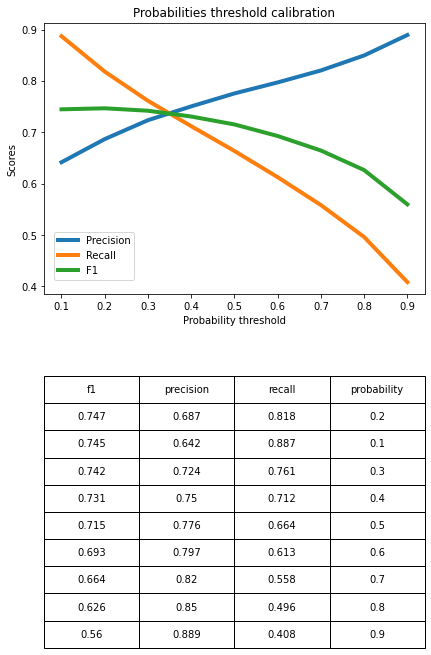

In [261]:
test_pred_proba = model.predict(X_valid)
test_pred = test_pred_proba.round()
show_proba_calibration_plots(test_pred_proba, y_val)

In [262]:
test_pred= np.where(test_pred_proba.round(2)>0.35, 1, 0)
get_classification_report(y_val, test_pred)

TEST

              precision    recall  f1-score   support

           0       0.73      0.74      0.73     11234
           1       0.74      0.73      0.74     11449

    accuracy                           0.73     22683
   macro avg       0.73      0.73      0.73     22683
weighted avg       0.73      0.73      0.73     22683



In [263]:
f1_metrics_models['gru_cnn'] = round(f1_score(y_val, test_pred),4)

In [264]:
print(f1_metrics_models)

{'cnn': 0.7339, 'simple_rnn': 0.747, 'lstm': 0.7508, 'gru': 0.7271, 'cnn_gru': 0.7201, 'gru_cnn': 0.736}


Вывод: лучше всех вариантов с задачей справилась lstm (по метрике f1), неплохо также справилась simple rnn.